##**Install required libraries**

In [5]:
!pip install tsfresh scikit-learn plotly pandas numpy


##**Import libraries**

In [6]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

In [7]:
import plotly.express as px
import plotly.graph_objects as go

##**Upload Dataset**

In [8]:
from google.colab import files
files.upload()

import pandas as pd
df = pd.read_csv("Sample_data.csv", parse_dates=['timestamp'])
df.head()


Saving Sample_data.csv to Sample_data.csv


,timestamp,heart_rate_bpm,sleep_hours,step_count,calories_burned,activity_type
0,2025-12-10 00:00:00,51,0.08,7,0.79,Sleeping
1,2025-12-10 00:05:00,50,0.17,0,0.50,Sleeping
2,2025-12-10 00:10:00,59,0.25,7,0.87,Sleeping
3,2025-12-10 00:15:00,56,0.33,4,0.72,Sleeping
4,2025-12-10 00:20:00,56,0.42,5,0.76,Sleeping


##**Sliding Windows + TSFresh Feature Extraction**

In [9]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters

# sliding windows
def build_windows(df, col, window=12):
    out=[]
    w=0
    for i in range(0, len(df)-window+1, window):
        temp=df.iloc[i:i+window][['timestamp',col]].copy()
        temp['window_id']=w
        out.append(temp)
        w+=1
    return pd.concat(out).rename(columns={col:'value'})

hr = df[['timestamp','heart_rate_bpm']].rename(columns={'heart_rate_bpm':'heart_rate'})
dfp = build_windows(hr,'heart_rate')

fc = MinimalFCParameters()

features = extract_features(
    dfp,
    column_id='window_id',
    column_sort='timestamp',
    default_fc_parameters=fc,
    n_jobs=0
)

features = impute(features)
features = features.loc[:, features.std()!=0]
features.head()


Feature Extraction: 100%|██████████| 168/168 [00:00<00:00, 1299.28it/s]


,value__sum_values,value__median,value__mean,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum
0,658.0,56.0,54.833333,3.184162,10.138889,54.925707,59.0,59.0,49.0
1,674.0,55.0,56.166667,4.336537,18.805556,56.333826,65.0,65.0,50.0
2,649.0,53.5,54.083333,3.925522,15.409722,54.225609,63.0,63.0,48.0
3,668.0,55.5,55.666667,2.867442,8.222222,55.740470,60.0,60.0,51.0
4,655.0,55.5,54.583333,2.871072,8.243056,54.658790,58.0,58.0,48.0


##**Rolling-Median Trend Modeling and Anomalies(3-Sigma)**

In [10]:
hr# 5-min HR series
hr_series = hr.set_index('timestamp')['heart_rate']

baseline = hr_series.rolling(window=12, center=True).median()
residual = hr_series - baseline
sigma = residual.std()

anomalies = residual[abs(residual) > 3*sigma]
print("Anomalies detected:", len(anomalies))

plot_df = pd.DataFrame({
    "timestamp": hr_series.index,
    "heart_rate": hr_series.values,
    "baseline": baseline.values
})

Anomalies detected: 31


#**Plot HR+Baseline+Anomalies**

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_df['timestamp'], y=plot_df['heart_rate'],
                         mode='lines', name='heart_rate'))
fig.add_trace(go.Scatter(x=plot_df['timestamp'], y=plot_df['baseline'],
                         mode='lines', name='baseline'))

# Add anomaly points in red
if len(anomalies) > 0:
    fig.add_trace(go.Scatter(x=anomalies.index,
                             y=hr_series.loc[anomalies.index].values,
                             mode='markers', name='anomalies',
                             marker=dict(color='red', size=6)))

fig.update_layout(title='Heart Rate Trend + Anomalies', height=520)
fig.show()


##**KMeans Clustering and PCA Visualization**

In [12]:
X = features.fillna(0)
Xs = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(Xs)

pca = PCA(n_components=2)
pcs = pca.fit_transform(Xs)

df_viz = pd.DataFrame({"pc1":pcs[:,0], "pc2":pcs[:,1], "cluster":labels})
px.scatter(df_viz, x="pc1", y="pc2", color="cluster",
           title="KMeans Clustering (PCA)").show()


##**DBSCAN Clustering + Silhouette Score**

In [13]:
from sklearn.metrics import silhouette_score

db = DBSCAN(eps=0.6, min_samples=5)
db_labels = db.fit_predict(Xs)

print("DBSCAN unique labels:", np.unique(db_labels))
print("Noise points:", np.sum(db_labels == -1))

# silhouette safely
try:
    sil_k = silhouette_score(Xs, labels)
except:
    sil_k = np.nan
try:
    sil_db = silhouette_score(Xs, db_labels)
except:
    sil_db = np.nan

print("KMeans silhouette:", sil_k)
print("DBSCAN silhouette:", sil_db)

# Visualize DBSCAN in PCA space
df_dbviz = pd.DataFrame({"pc1": pcs[:,0], "pc2": pcs[:,1],
                         "cluster": db_labels.astype(str)})
px.scatter(df_dbviz, x="pc1", y="pc2", color="cluster",
           title="DBSCAN Clustering (PCA)").show()


DBSCAN unique labels: [-1  0  1  2  3  4  5  6]
Noise points: 20
KMeans silhouette: 0.4898982438218156
DBSCAN silhouette: 0.29502199910001253


##**Facebook Prophet**

Prophet imported successfully.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Prophet worked successfully!


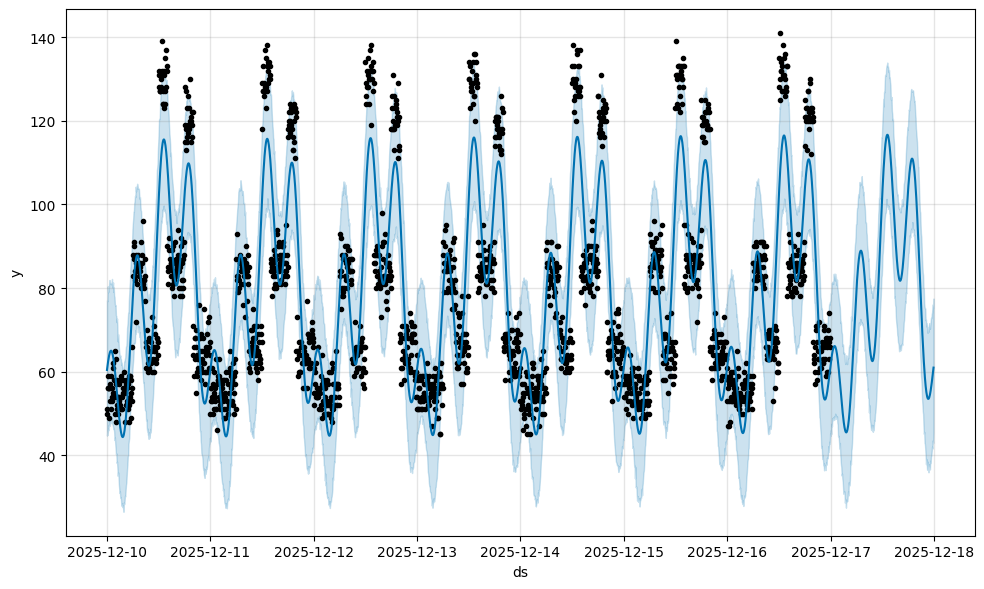

In [14]:
try:
    from prophet import Prophet
    print("Prophet imported successfully.")

    prophet_df = hr.rename(columns={'timestamp':'ds','heart_rate':'y'})[['ds','y']]

    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=24*12, freq='5min')
    forecast = model.predict(future)

    # show forecast plot
    fig = model.plot(forecast)
    fig.show()

    print("Prophet worked successfully!")

except Exception as e:
    print("Prophet could not run. Reason:", str(e))
    print("Trend modeling already completed using rolling median.")
